# Spotify Song Popularity Prediction

This notebook implements a machine learning model to predict song popularity on Spotify using various audio features.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Loading and Exploration](#data)
3. [Data Preprocessing & Feature Engineering](#preprocessing)
4. [Model Training](#training)
5. [Model Evaluation](#evaluation)

## 1. Setup and Imports <a id='setup'></a>

In [43]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
sns.set_theme(style="white")

## 2. Data Loading and Exploration <a id='data'></a>

In [44]:
# Load the dataset
df = pd.read_csv('../data/raw/spotify_songs.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (32833, 23)

First few rows:


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [45]:
# Drop unnecessary columns
df.drop(columns=['track_id', 'track_name', 'track_artist', 'track_album_id', 'track_album_name', 'playlist_id', 'playlist_name'], inplace=True)

In [46]:
# Check data info
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_popularity          32833 non-null  int64  
 1   track_album_release_date  32833 non-null  object 
 2   playlist_genre            32833 non-null  object 
 3   playlist_subgenre         32833 non-null  object 
 4   danceability              32833 non-null  float64
 5   energy                    32833 non-null  float64
 6   key                       32833 non-null  int64  
 7   loudness                  32833 non-null  float64
 8   mode                      32833 non-null  int64  
 9   speechiness               32833 non-null  float64
 10  acousticness              32833 non-null  float64
 11  instrumentalness          32833 non-null  float64
 12  liveness                  32833 non-null  float64
 13  valence                   32833 non-null  float

In [47]:
# Update data types
# Define data types for each column
dtypes = {
    'track_popularity': 'int32',
    'track_album_release_date': 'datetime64[ns]',
    'playlist_genre': 'category', 
    'playlist_subgenre': 'category',
    'danceability': 'float32',
    'energy': 'float32',
    'key': 'int8',
    'loudness': 'float32', 
    'mode': 'category',
    'speechiness': 'float32',
    'acousticness': 'float32',
    'instrumentalness': 'float32',
    'liveness': 'float32',
    'valence': 'float32',
    'tempo': 'float32',
    'duration_ms': 'int32'
}

# Update data types
df = df.astype(dtypes)

Note: **'Key'** is a categorical variable but is encoded as an integer. More on this in the [Data Preprocessing & Feature Selection](#3.-Data-Preprocessing-&-Feature-Engineering) section.


In [48]:
# Calculate number of unique categories for categorical variables
print("Number of unique categories in categorical variables:")
categorical_features = df.select_dtypes(include=['category']).columns
for col in categorical_features:
    print(f"{col}: {df[col].nunique()}")

Number of unique categories in categorical variables:
playlist_genre: 6
playlist_subgenre: 24
mode: 2


In [49]:
# Basic statistical description
df.describe()

,track_popularity,track_album_release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,2011-08-07 17:30:40.185179648,0.654850,0.698619,5.374471,-6.719499,0.107068,0.175334,0.084747,0.190176,0.510561,120.881134,225799.811622
min,0.000000,1957-01-01 00:00:00,0.000000,0.000175,0.000000,-46.448002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,2008-08-25 00:00:00,0.563000,0.581000,2.000000,-8.171000,0.041000,0.015100,0.000000,0.092700,0.331000,99.959999,187819.000000
50%,45.000000,2016-08-26 00:00:00,0.672000,0.721000,6.000000,-6.166000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984001,216000.000000
75%,62.000000,2019-04-19 00:00:00,0.761000,0.840000,9.000000,-4.645000,0.132000,0.255000,0.004830,0.248000,0.693000,133.917999,253585.000000
max,100.000000,2020-01-29 00:00:00,0.983000,1.000000,11.000000,1.275000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440002,517810.000000
std,24.984074,NaN,0.145085,0.180910,3.611657,2.988436,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182


In [50]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
track_popularity            0
track_album_release_date    0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64


The dataset appears to have no missing values. However, according to the data documentation, the `key` column has missing values encoded as `-1`. We will address this in the next section: [Data Preprocessing & Feature Selection](#3.-Data-Preprocessing-&-Feature-Engineering).



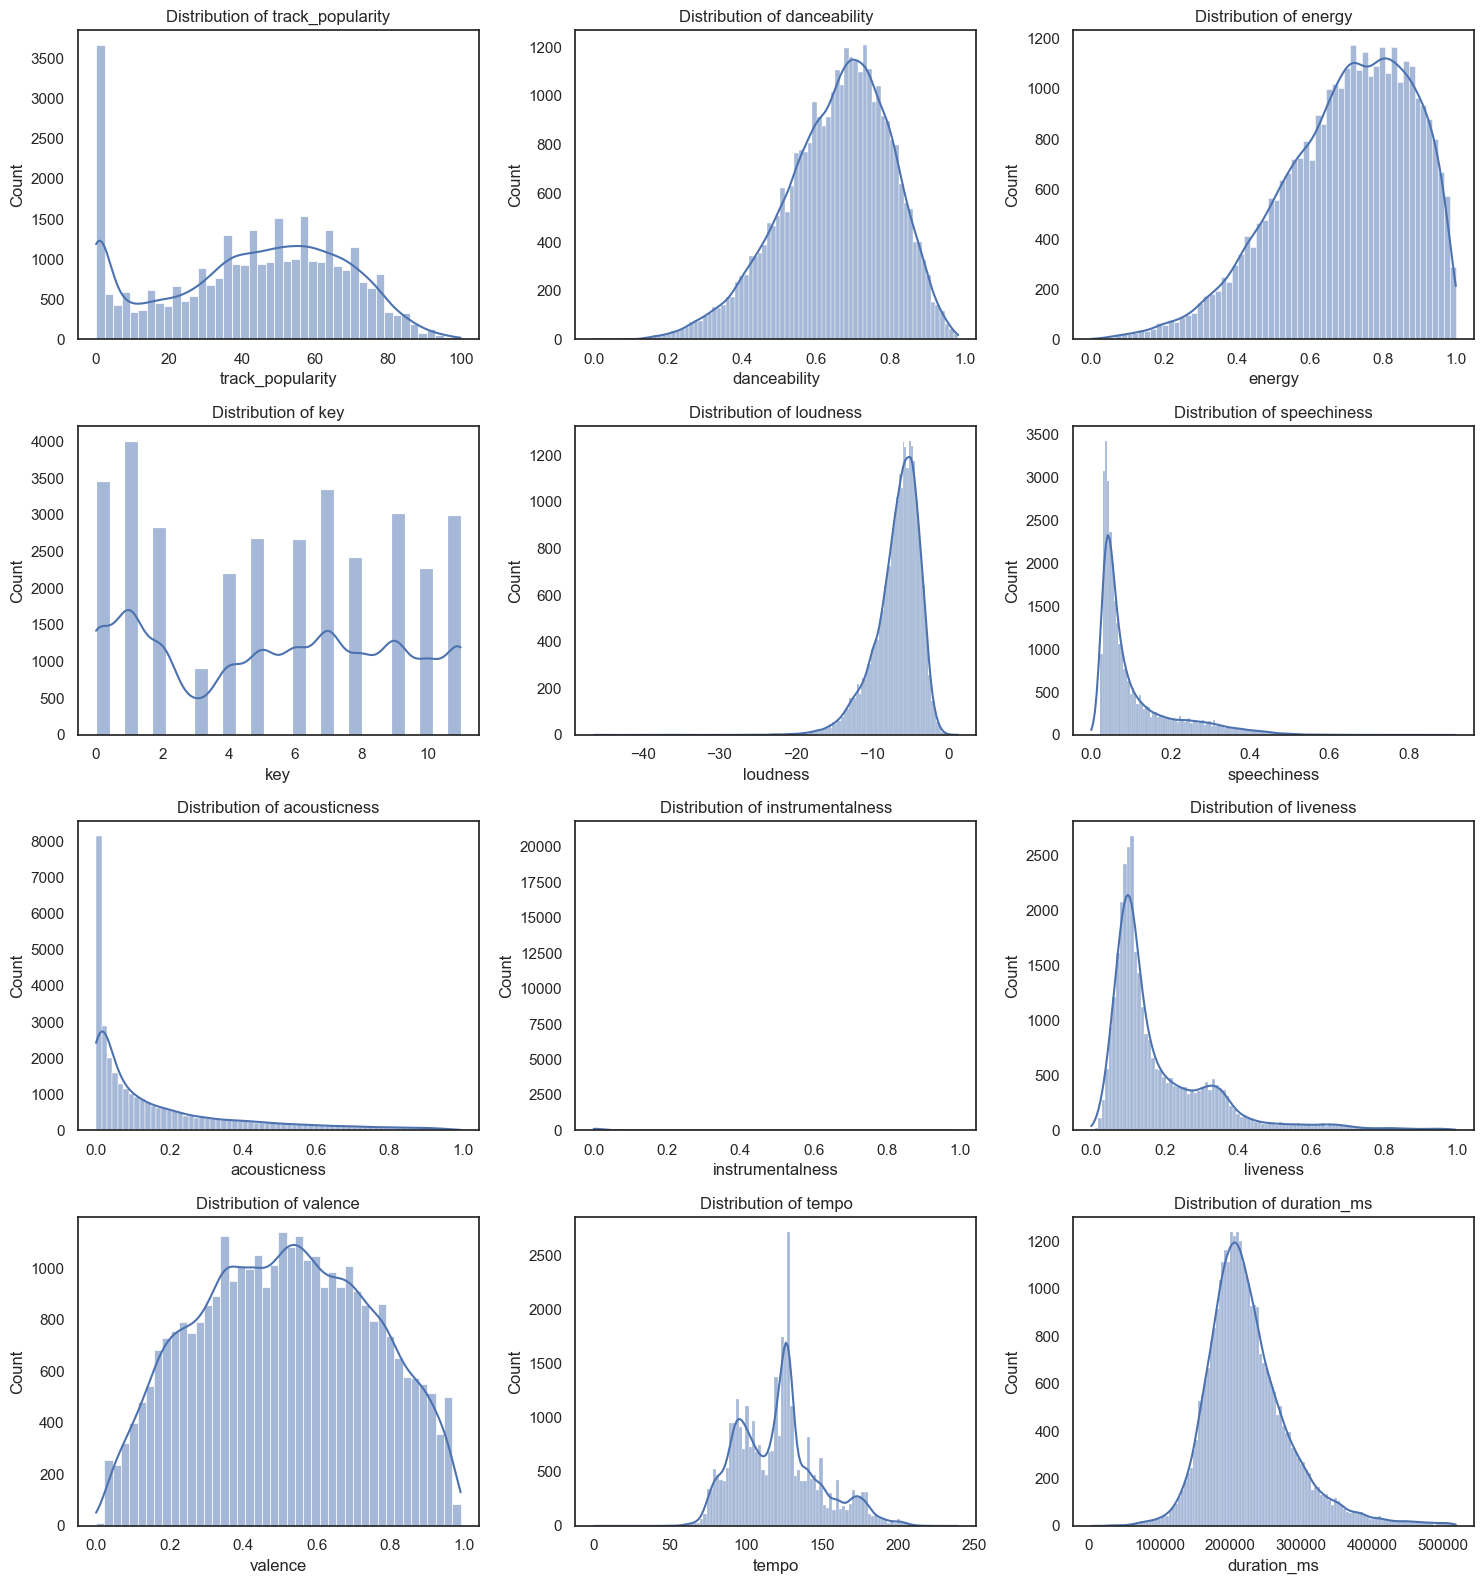

In [51]:
# Create a distribution plot for each numeric column
df_numerical_features = df.select_dtypes(include=['int8', 'int32', 'float32']).columns

n_rows = (len(df_numerical_features) + 1) // 3
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 4 * n_rows))
axes = axes.flatten() 

for i, (ax, col) in enumerate(zip(axes, df_numerical_features)):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

# Hide empty subplots if odd number of features
if len(df_numerical_features) % 2 != 0:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

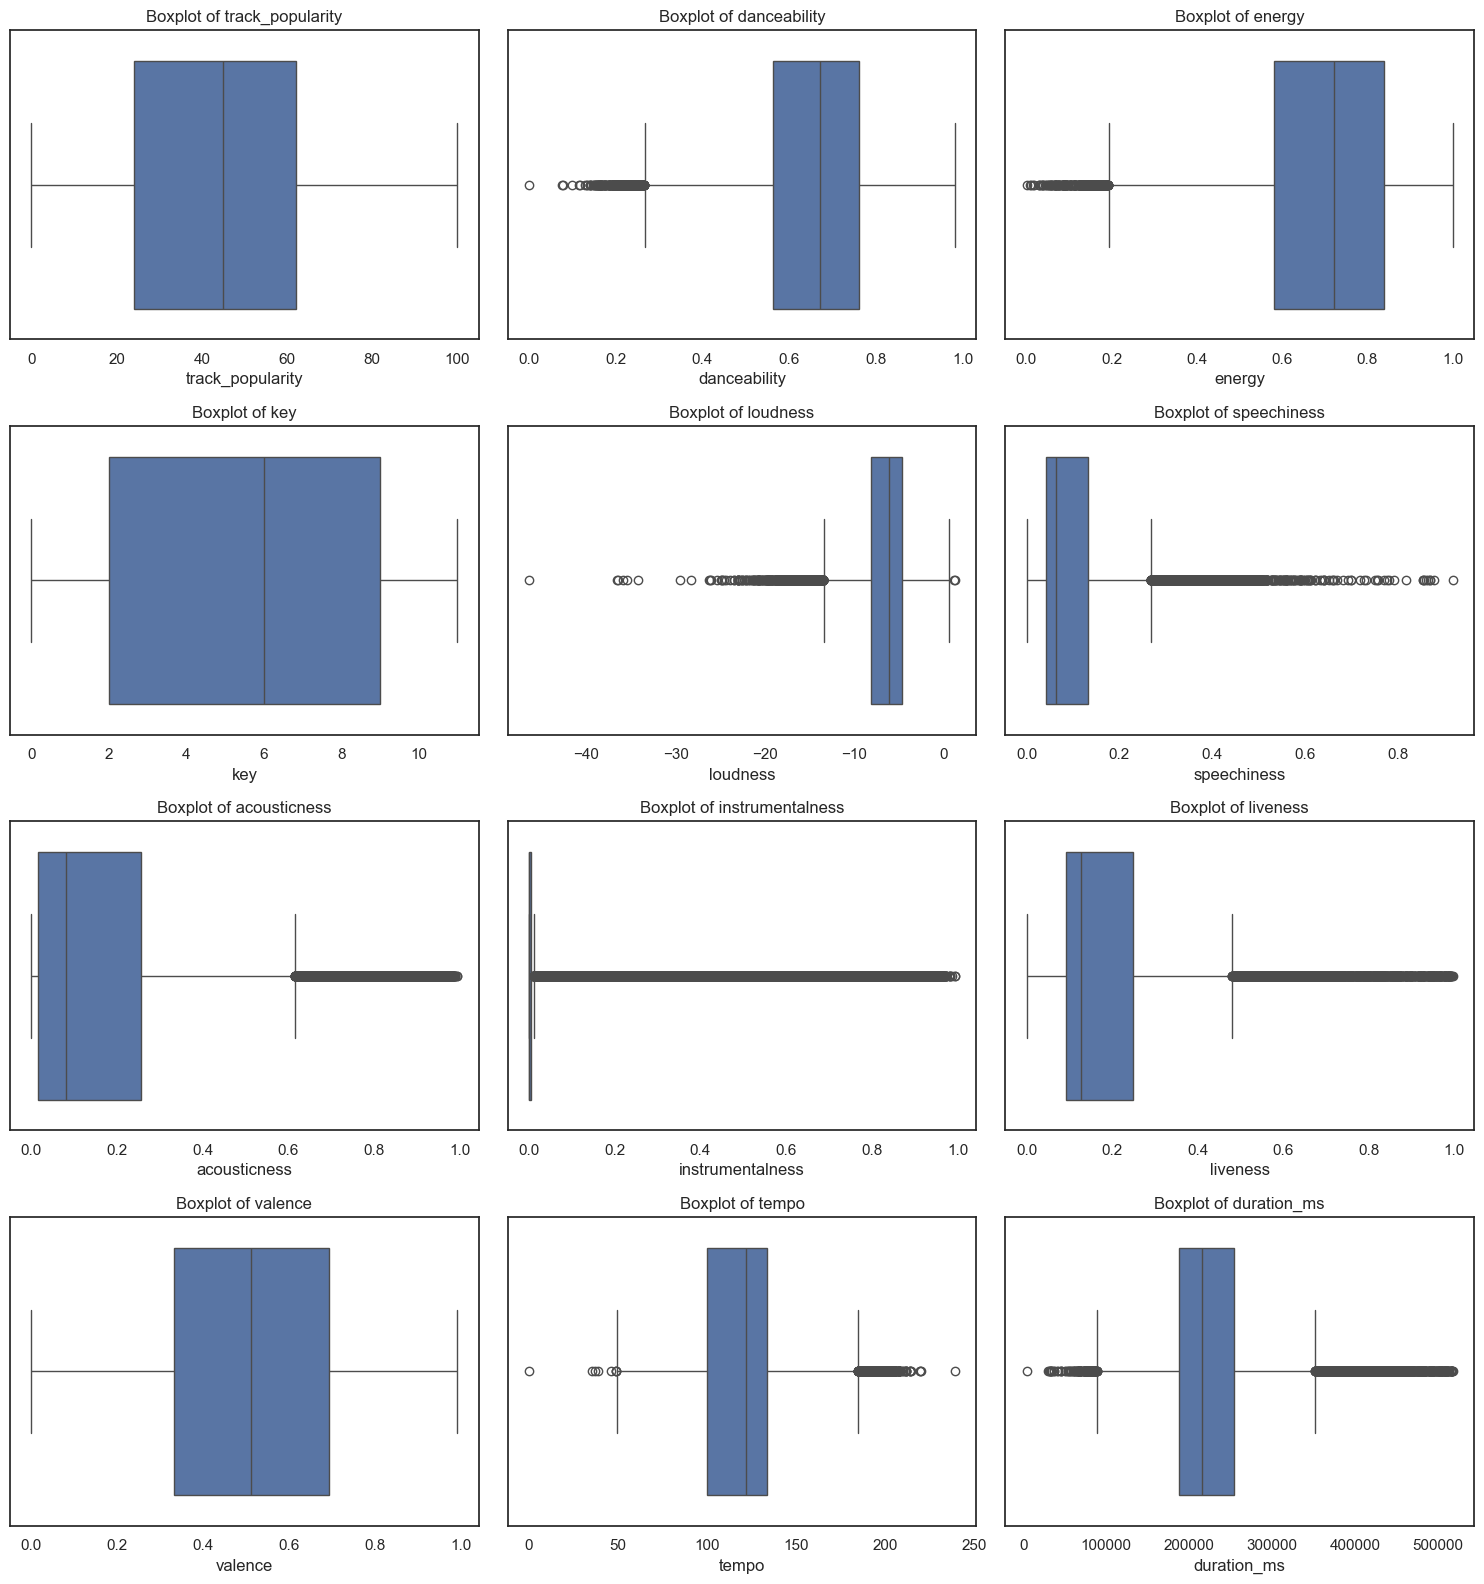

In [52]:
# Visualize outliers in numerical columns

n_rows = (len(df_numerical_features) + 1) // 3
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 4 * n_rows))
axes = axes.flatten() 

for i, (ax, col) in enumerate(zip(axes, df_numerical_features)):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(f'Boxplot of {col}')

# Hide empty subplots if odd number of features
if len(df_numerical_features) % 3 != 0:
    for ax in axes[len(df_numerical_features):]:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


#### Do we need to clean the data for outliers?

1. **Tree-based models (XGBoost, LightGBM, CatBoost) are robust to outliers** since they split data into bins rather than fitting continuous functions.  
2. **Large dataset size minimizes the impact of extreme values**, making explicit outlier treatment unnecessary.  
3. **Outliers may contain valuable insights**, and removing them risks losing important patterns.  
4. **Categorical data is unaffected by outliers**, and encoding methods handle variations naturally.  
5. **Regularization and loss functions manage extreme values**, reducing their influence without manual removal.  

Given these factors, outlier cleaning is unnecessary for this dataset.


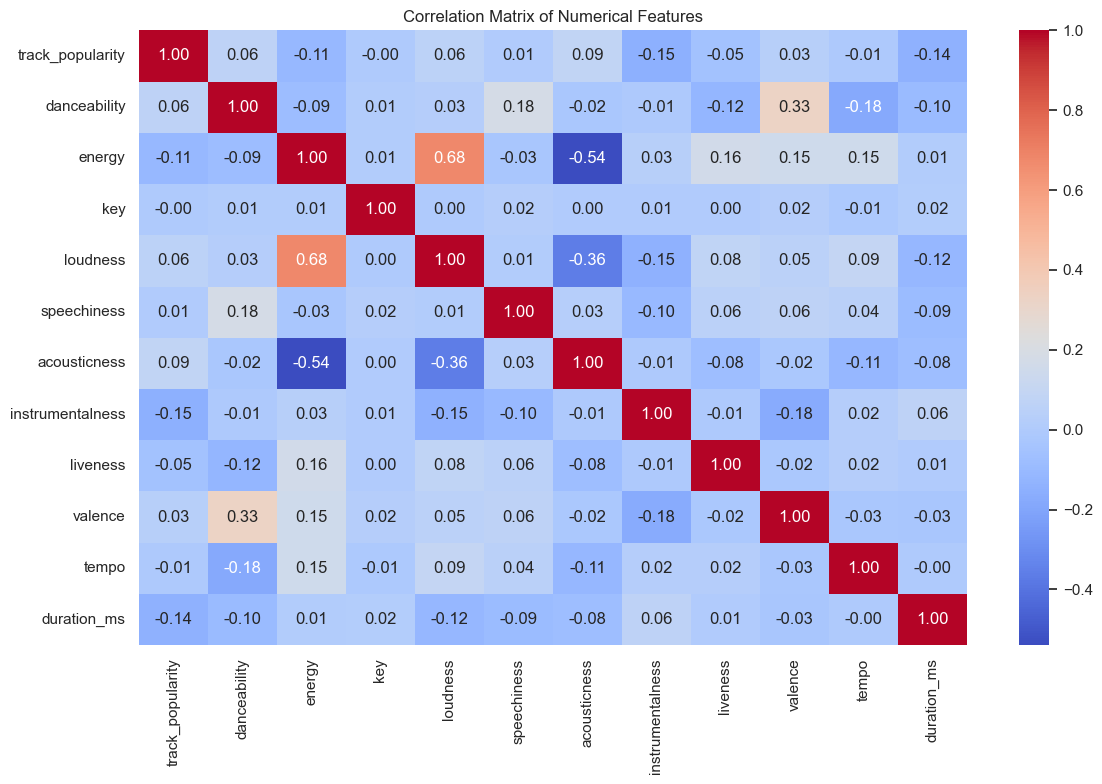

In [53]:
# Correlation matrix for numerical features
correlation_matrix = df[df_numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

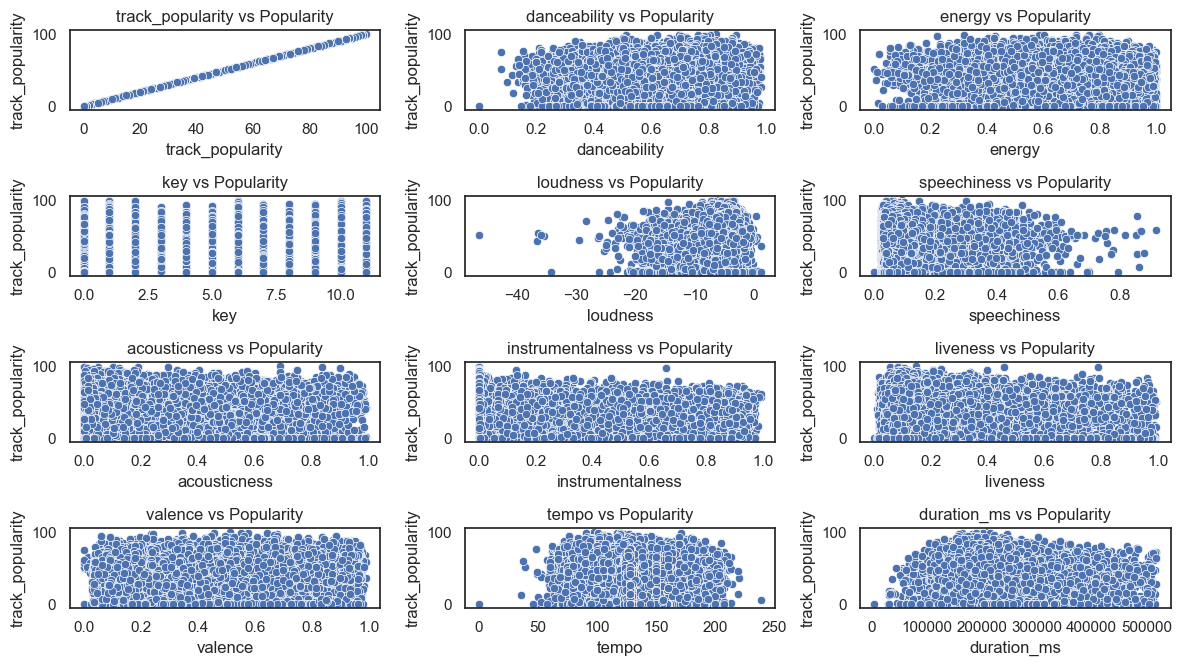

In [54]:
# Visulize the relationship between numerical features and the target variable
plt.figure(figsize=(12, 8))
for i, feature in enumerate(df_numerical_features):
    plt.subplot(5, 3, i + 1)
    sns.scatterplot(data=df, x=feature, y='track_popularity')
    plt.title(f'{feature} vs Popularity')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing & Feature Engineering <a id='preprocessing'></a>

### Encoding Cyclical Variables (Key & Month) with Sine & Cosine

**Key Definition**  
**`key`**: The estimated overall key of the track (0 = C, 1 = C♯/D♭, ..., 11 = B). If no key is detected, the value is `-1`.

Both **`key`** (0–11) and **release_month** (1–12) are naturally **cyclical**. To preserve adjacency (e.g., key 0 near key 11; month 12 near month 1), we encode them with **sine** and **cosine**:

$$
\text{key\_sin} = \sin\!\Bigl(2\pi \cdot \frac{\text{key}}{12}\Bigr), \quad
\text{key\_cos} = \cos\!\Bigl(2\pi \cdot \frac{\text{key}}{12}\Bigr);
$$

$$
\text{release\_month\_sin}(m) = \sin\!\Bigl(\frac{2\pi \times m}{12}\Bigr), \quad
\text{release\_month\_cos}(m) = \cos\!\Bigl(\frac{2\pi \times m}{12}\Bigr).
$$

**Why Both Sine & Cosine?**  
1. **2D Representation**  
   A single trigonometric function (e.g., only sine) flattens the circle to a line, losing adjacency (e.g., January next to December). Using **both** sine and cosine maps each key/month to a **unique 2D point**, preserving cyclical distance.

2. **Avoiding Ambiguities**  
   Sine alone can yield the same magnitude for angles \(\theta\) and \(\theta+\pi\). Adding cosine disambiguates these positions, preventing overlap.

**Handling `-1` for Key**  
Tracks with `key = -1` (no key detected) should have their `key_sin` and `key_cos` set to `NaN`, ensuring they don’t overlap with valid keys.


In [55]:
def preprocess_and_engineer_features(df):
    """
    Preprocess and engineer new features for the Spotify dataset.
    """
    df_featured = df.copy()
    
    # Encode key with sine & cosine
    if 'key' in df_featured.columns:
        df_featured['key_sin'] = np.sin(2 * np.pi * df_featured['key'] / 12)
        df_featured['key_cos'] = np.cos(2 * np.pi * df_featured['key'] / 12)
        df_featured.loc[df_featured['key'] == -1, ['key_sin', 'key_cos']] = np.nan
        df_featured.drop(columns='key', inplace=True)

    # Audio feature engineering
    if all(col in df_featured.columns for col in ['energy', 'danceability']):
        df_featured['energy_dance_ratio'] = df_featured['energy'] / df_featured['danceability']
        df_featured['energy_dance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    if all(col in df_featured.columns for col in ['acousticness', 'energy']):
        df_featured['acoustic_energy_balance'] = df_featured['acousticness'] - df_featured['energy']
    
    if all(col in df_featured.columns for col in ['valence', 'energy']):
        df_featured['mood_score'] = df_featured['valence'] * df_featured['energy']
    
    # Tempo categories
    if 'tempo' in df_featured.columns:
        df_featured['tempo_category'] = pd.qcut(df_featured['tempo'], 4, 
                                              labels=['slow', 'medium', 'fast', 'very_fast'])

    # Release date features
    if 'track_album_release_date' in df_featured.columns:
        df_featured['track_album_release_date'] = pd.to_datetime(df_featured['track_album_release_date'], 
                                                               errors='coerce')
        
        df_featured['release_year'] = df_featured['track_album_release_date'].dt.year
        df_featured['release_month'] = df_featured['track_album_release_date'].dt.month
        df_featured['release_day'] = df_featured['track_album_release_date'].dt.day
        
        # Cyclical month encoding
        month = 2 * np.pi * df_featured['release_month'] / 12
        df_featured['release_month_sin'] = np.sin(month)
        df_featured['release_month_cos'] = np.cos(month)

        df_featured['track_age_years'] = datetime.now().year - df_featured['release_year']
        
        df_featured.drop(columns='track_album_release_date', inplace=True)

    return df_featured

# Engineer features
df_featured = preprocess_and_engineer_features(df)

# Display new features
print("New Features:")
new_features = ['key_sin', 'key_cos', 'energy_dance_ratio', 'acoustic_energy_balance', 'mood_score', 'tempo_category', 'release_month_sin', 'release_month_cos']
df_featured[new_features].head()

New Features:


C:\Users\ahlaw\AppData\Local\Temp\ipykernel_21324\2393639747.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_featured['energy_dance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)


,key_sin,key_cos,energy_dance_ratio,acoustic_energy_balance,mood_score,tempo_category,release_month_sin,release_month_cos
0,1.224647e-16,-1.000000,1.224599,-0.8140,0.474488,fast,1.224647e-16,-1.000000e+00
1,-5.000000e-01,0.866025,1.122589,-0.7426,0.564795,medium,-2.449294e-16,1.000000e+00
2,5.000000e-01,0.866025,1.379259,-0.8516,0.570703,fast,-5.000000e-01,-8.660254e-01
3,-5.000000e-01,-0.866025,1.295265,-0.9013,0.257610,medium,-5.000000e-01,-8.660254e-01
4,5.000000e-01,0.866025,1.281538,-0.7527,0.603925,fast,1.000000e+00,6.123234e-17


## 4. Model Training <a id='training'></a>

In [56]:
df_featured.dtypes

track_popularity              int32
playlist_genre             category
playlist_subgenre          category
danceability                float32
energy                      float32
loudness                    float32
mode                       category
speechiness                 float32
acousticness                float32
instrumentalness            float32
liveness                    float32
valence                     float32
tempo                       float32
duration_ms                   int32
key_sin                     float64
key_cos                     float64
energy_dance_ratio          float32
acoustic_energy_balance     float32
mood_score                  float32
tempo_category             category
release_year                  int32
release_month                 int32
release_day                   int32
release_month_sin           float64
release_month_cos           float64
track_age_years               int32
dtype: object

In [57]:
# Prepare features and target
X = df_featured.drop(columns='track_popularity')
y = df_featured['track_popularity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
df_f_numeric_features = X.select_dtypes(include=['int32', 'float32', 'float64']).columns
df_f_categorical_features = X.select_dtypes(include=['category']).columns


In [58]:
# Train XGBoost model with categorical features
xgb_pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), df_f_numeric_features),
            ('cat', OneHotEncoder(sparse_output=False), df_f_categorical_features)
        ]
    )),
    ('regressor', xgb.XGBRegressor(random_state=42))
])

xgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best XGBoost parameters:", xgb_grid.best_params_)

KeyboardInterrupt: 

In [17]:
# Train LightGBM model
lgb_pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), df_f_numeric_features),
            ('cat', OneHotEncoder(sparse_output=False), df_f_categorical_features)
        ]
    )),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

lgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__num_leaves': [31, 63],
    'regressor__learning_rate': [0.01, 0.1]
}

lgb_grid = GridSearchCV(lgb_pipeline, lgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X_train, y_train)

print("Best LightGBM parameters:", lgb_grid.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3598
[LightGBM] [Info] Number of data points in the train set: 26266, number of used features: 57
[LightGBM] [Info] Start training from score 42.546334
Best LightGBM parameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200, 'regressor__num_leaves': 63}


In [18]:
# Train CatBoost model
cat_pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), df_f_numeric_features),
            ('cat', 'passthrough', df_f_categorical_features)
        ]
    )),
    ('regressor', CatBoostRegressor(
        random_state=42, 
        verbose=False, 
        task_type="CPU",
        cat_features=[i + len(df_f_numeric_features) for i in range(len(df_f_categorical_features))]
    ))
])

cat_params = {
    'regressor__iterations': [100, 200],
    'regressor__depth': [4, 6],
    'regressor__learning_rate': [0.01, 0.1]
}

cat_grid = GridSearchCV(cat_pipeline, cat_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cat_grid.fit(X_train, y_train)

print("Best CatBoost parameters:", cat_grid.best_params_)

Best CatBoost parameters: {'regressor__depth': 6, 'regressor__iterations': 200, 'regressor__learning_rate': 0.1}


## 5. Model Evaluation <a id='evaluation'></a>

In [19]:
# Model evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance with comprehensive metrics."""
    y_pred = model.predict(X_test)
    
    # Basic metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"Residual Range: [{residuals.min():.2f}, {residuals.max():.2f}]")
    
    return y_pred, residuals

# Evaluate the three models 
models = {
    'XGBoost': xgb_grid,
    'LightGBM': lgb_grid,
    'CatBoost': cat_grid}
        


XGBoost Performance Metrics:
RMSE: 20.58
R² Score: 0.318
MAE: 16.77
Residual Range: [-71.93, 57.52]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3598
[LightGBM] [Info] Number of data points in the train set: 26266, number of used features: 57
[LightGBM] [Info] Start training from score 42.546334


c:\Users\ahlaw\OneDrive - UBC\Documents\vscode\Projects\Spotify_Popularity_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



LightGBM Performance Metrics:
RMSE: 20.48
R² Score: 0.324
MAE: 16.73
Residual Range: [-63.50, 60.06]

CatBoost Performance Metrics:
RMSE: 21.45
R² Score: 0.259
MAE: 17.74
Residual Range: [-67.79, 51.87]



XGBoost Performance Metrics:
RMSE: 20.58
R² Score: 0.318
MAE: 16.77
Residual Range: [-71.93, 57.52]

LightGBM Performance Metrics:
RMSE: 20.48
R² Score: 0.324
MAE: 16.73
Residual Range: [-63.50, 60.06]


c:\Users\ahlaw\OneDrive - UBC\Documents\vscode\Projects\Spotify_Popularity_Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



CatBoost Performance Metrics:
RMSE: 21.45
R² Score: 0.259
MAE: 17.74
Residual Range: [-67.79, 51.87]


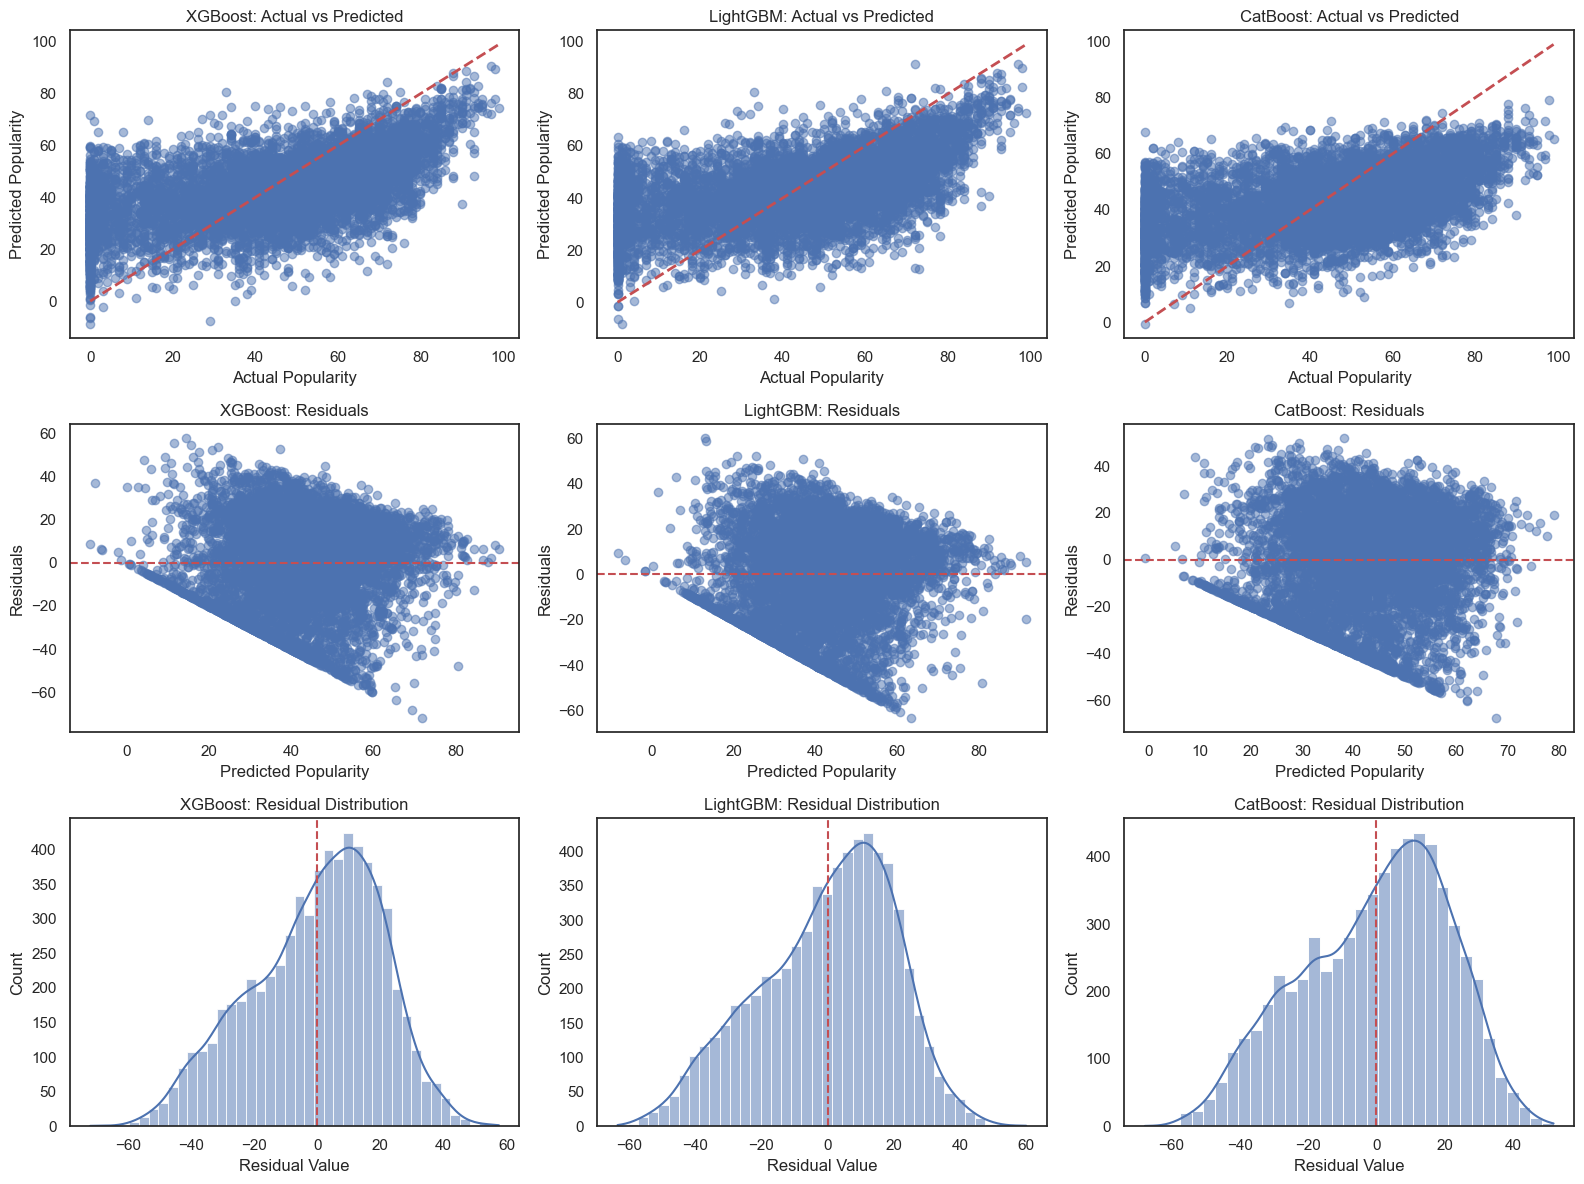

{'XGBoost': {'y_pred': array([45.802776, 35.896782, 36.68913 , ..., 32.105682, 41.74469 ,
         42.112587], dtype=float32),
  'residuals': 30056    -0.802776
  11827   -18.896782
  23571    -6.689129
  14741     6.861763
  25570    30.549906
             ...    
  18220     1.734871
  28878   -12.261637
  11570   -30.105682
  1662    -41.744690
  8025     -2.112587
  Name: track_popularity, Length: 6567, dtype: float64},
 'LightGBM': {'y_pred': array([41.42578199, 33.12673349, 35.32660903, ..., 33.52680868,
         49.14540998, 43.00578482]),
  'residuals': 30056     3.574218
  11827   -16.126733
  23571    -5.326609
  14741     8.581737
  25570    32.511511
             ...    
  18220     3.659064
  28878   -17.259570
  11570   -31.526809
  1662    -49.145410
  8025     -3.005785
  Name: track_popularity, Length: 6567, dtype: float64},
 'CatBoost': {'y_pred': array([48.15836091, 40.61321967, 43.08100474, ..., 32.2435483 ,
         55.64559857, 40.83552716]),
  'residuals': 30056 

In [20]:
# Plot model comparisons function
def plot_model_comparisons(models, X_test, y_test):
    """Create comprehensive comparison visualizations for multiple models."""
    # Store results
    results = {}
    
    plt.figure(figsize=(16, 12))
    
    # Evaluate each model
    for i, (model_name, model) in enumerate(models.items()):
        y_pred, residuals = evaluate_model(model, X_test, y_test, model_name)
        results[model_name] = {'y_pred': y_pred, 'residuals': residuals}
        
        # Actual vs Predicted plot
        plt.subplot(3, 3, i+1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title(f'{model_name}: Actual vs Predicted')
        plt.xlabel('Actual Popularity')
        plt.ylabel('Predicted Popularity')
        
        # Residuals plot
        plt.subplot(3, 3, i+4)
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'{model_name}: Residuals')
        plt.xlabel('Predicted Popularity')
        plt.ylabel('Residuals')
        
        # Residual distribution
        plt.subplot(3, 3, i+7)
        sns.histplot(residuals, kde=True)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title(f'{model_name}: Residual Distribution')
        plt.xlabel('Residual Value')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Plot model comparisons
plot_model_comparisons(models, X_test, y_test)